In [1]:
this_notebook_name = "SagittalSpineSegmentationStudy"

# Update this folder name for your computer

local_data_folder = r"c:\Data\SagittalSpineSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 500
batch_size = 64
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 10
class_weights = np.array([0.1, 0.9])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_validation_rounds = -1

# Uncomment for faster debugging

# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01, 0.001]
# limit_validation_rounds = 1
# num_epochs = 10

Save timestamp: 2020-01-07_12-33-21


In [2]:
import os
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import ultrasound_batch_generator as generator
import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

In [3]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5da9e5c0d9e6a3be02d012b4",
    "5da9e5c7d9e6a3be02d012c6",
    "5da9e5c2d9e6a3be02d012b7",
    "5da9e5c3d9e6a3be02d012ba",
    "5da9e5c8d9e6a3be02d012c9",
    "5da9e5c5d9e6a3be02d012c0",
    "5da9e5c6d9e6a3be02d012c3",
    "5da9e5c4d9e6a3be02d012bd"
]

training_ultrasound_filenames = [
    "q000_ultrasound.npy",
    "q001_ultrasound.npy",
    "q002_ultrasound.npy",
    "q003_ultrasound.npy",
    "q004_ultrasound.npy",
    "q005_ultrasound.npy",
    "q006_ultrasound.npy",
    "q007_ultrasound.npy"
]

training_segmentation_ids = [
    "5da9e5c8d9e6a3be02d012cc",
    "5da9e5ccd9e6a3be02d012de",
    "5da9e5c9d9e6a3be02d012cf",
    "5da9e5cad9e6a3be02d012d2",
    "5da9e5cdd9e6a3be02d012e1",
    "5da9e5cbd9e6a3be02d012d8",
    "5da9e5cbd9e6a3be02d012db",
    "5da9e5cad9e6a3be02d012d5"
]

training_segmentation_filenames = [
    "q000_segmentation.npy",
    "q001_segmentation.npy",
    "q002_segmentation.npy",
    "q003_segmentation.npy",
    "q004_segmentation.npy",
    "q005_segmentation.npy",
    "q006_segmentation.npy",
    "q007_segmentation.npy"
]

In [4]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

In [5]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

# Setting up number of validation rounds

n_files = len(training_ultrasound_ids)
if limit_validation_rounds > 0:
    num_validation_rounds = min(n_files, limit_validation_rounds)
else:
    num_validation_rounds = n_files

# Preparing progress bar

f = IntProgress(min=0, max=n_files*2)
display(f)

# Downloading files

gclient = girder_client.GirderClient(apiUrl=girder_api_url)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=16)


Total download time: 0:00:00.011968


In [6]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=16)


Total time to load from files: 0:00:00.070811


Timestamp for saved files: 2020-01-07_12-33-21

Training parameters
Number of epochs:    200
Step size maximum:   0.02
Step size decay:     9.995e-05
Batch size:          64
Regularization rate: 0.0001

Saving validation predictions in: c:\Data\SagittalSpineSegmentationStudy\PredictionsValidation
Saving models in:                 c:\Data\SagittalSpineSegmentationStudy\SavedModels

*** Leave-one-out round # 0

Training on 2767 images, validating on 523 images...
Validation ultrasound data shape:            (523, 128, 128, 1)
Validation segmentation data shape:          (523, 128, 128, 1)
Validation segmentation data (onehot) shape: (523, 128, 128, 2)


c:\D\tf2\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Metrics at the end of training
  val_acc:       0.9932772517204285
  val loss:      0.0024764666644235453
  Training time: 0:27:35.152286

Total round time:  0:27:48.230414


*** Leave-one-out round # 1

Training on 2935 images, validating on 355 images...
Validation ultrasound data shape:            (355, 128, 128, 1)
Validation segmentation data shape:          (355, 128, 128, 1)
Validation segmentation data (onehot) shape: (355, 128, 128, 2)

Metrics at the end of training
  val_acc:       0.9956575632095337
  val loss:      0.0032892830592269697
  Training time: 0:28:41.912426

Total round time:  0:28:50.656322


*** Leave-one-out round # 2

Training on 2813 images, validating on 477 images...
Validation ultrasound data shape:            (477, 128, 128, 1)
Validation segmentation data shape:          (477, 128, 128, 1)
Validation segmentation data (onehot) shape: (477, 128, 128, 2)

Metrics at the end of training
  val_acc:       0.9936392903327942
  val loss:      0.0025754438829

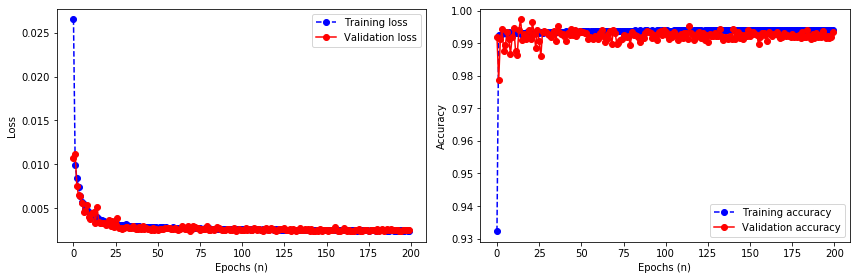

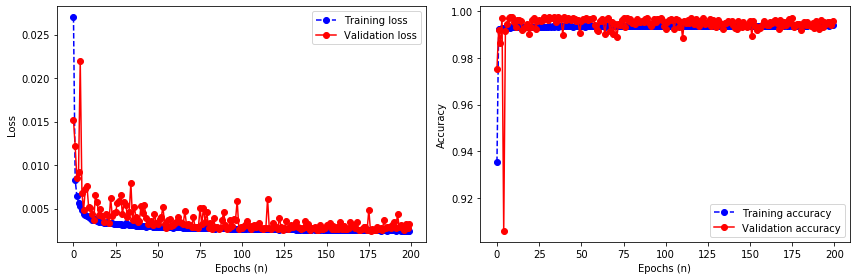

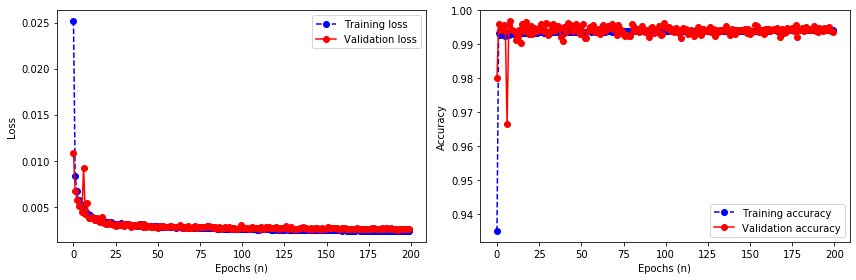

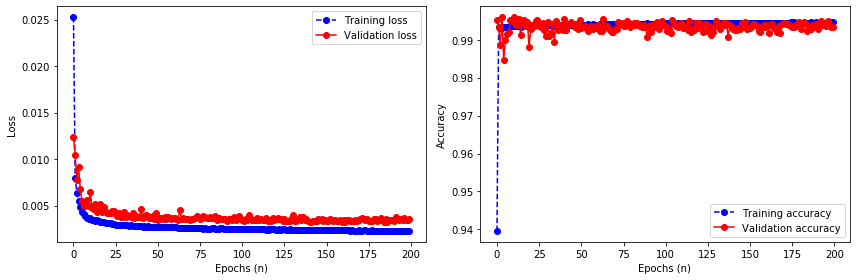

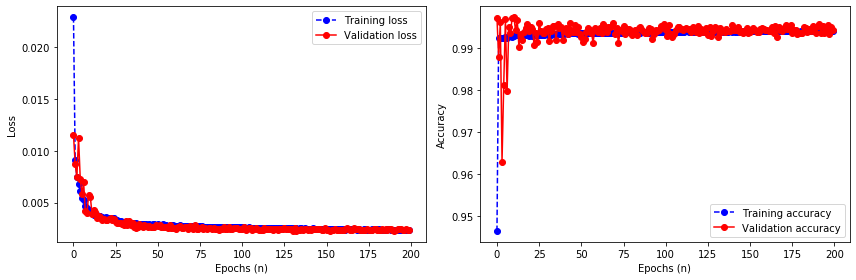

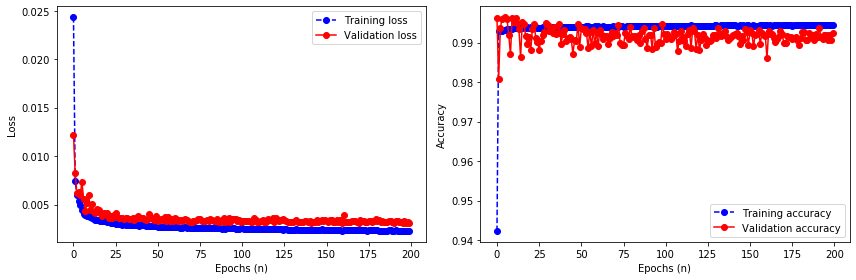

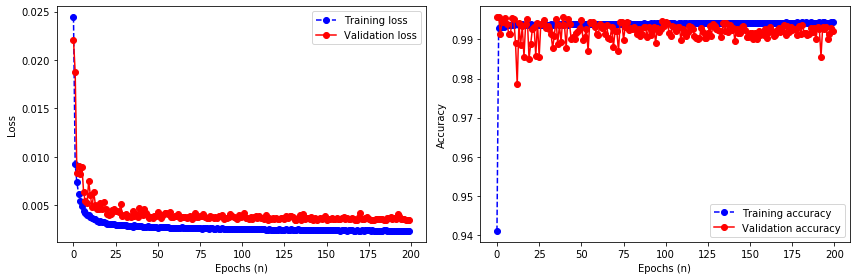

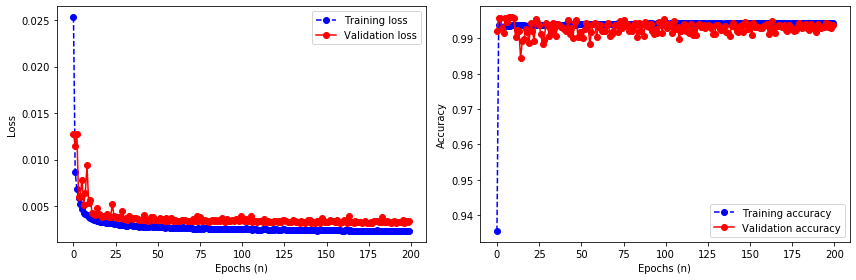

In [7]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for i in range(num_validation_rounds):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    train_segmentation_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    
    val_ultrasound_data = ultrasound_arrays[i]
    val_segmentation_data = segmentation_arrays[i]
    val_ultrasound_filename = training_ultrasound_filenames[i]
    
    for train_index in range(n_files):
        if train_index != i:
            train_ultrasound_data = np.concatenate((train_ultrasound_data, ultrasound_arrays[train_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data, segmentation_arrays[train_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(i))
    print("\nTraining on {} images, validating on {} images...".format(n_train, n_val))
    
    val_segmentation_data_onehot = tf.keras.utils.to_categorical(val_segmentation_data, num_classes)
    
    print("Validation ultrasound data shape:            {}".format(val_ultrasound_data.shape))
    print("Validation segmentation data shape:          {}".format(val_segmentation_data.shape))
    print("Validation segmentation data (onehot) shape: {}".format(val_segmentation_data_onehot.shape))
    
    # Create and train model
    
    model = unet.sagittal_spine_unet(ultrasound_size, num_classes, filter_multiplier, regularization_rate)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
        # loss=tf.keras.losses.categorical_crossentropy,
        loss=unet.weighted_categorical_crossentropy(class_weights),
        metrics=["accuracy"]
    )
        
    # model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(
        training_generator,
        validation_data=(val_ultrasound_data, val_segmentation_data_onehot),
        epochs=num_epochs,
        verbose=0
    )
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("\nMetrics at the end of training")
    print("  val_acc:       {}".format(training_log.history['val_accuracy'][-1]))
    print("  val loss:      {}".format(training_log.history['val_loss'][-1]))
    # print("  val_dice:      {}".format(training_log.history['val_dice_coef'][-1]))
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['accuracy'], 'bo--')
    axes[1].plot(training_log.history['val_accuracy'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on validation data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    
    # Saving predictions for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = save_timestamp + "_prediction_" + filename_noext + ".npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    np.save(val_prediction_fullname, y_pred_val)
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(i) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    
    # Validation results
    
    vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_best_metrics[i]    = vali_metrics_dicts[vali_best_threshold_index]
    val_aurocs[i]          = vali_area
    val_best_thresholds[i] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [8]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    results_df.loc[i] = [
        val_aurocs[i],
        val_best_thresholds[i],
        val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.RECALL],
        val_best_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.RECALL],
        val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore
0,0.994018,0.020,0.987908,0.026896,0.987908,0.093740,0.755428,0.248574,0.374062
1,0.978110,0.004,0.967447,0.042607,0.967447,0.054065,0.589328,0.266352,0.366886
2,0.995257,0.020,0.986880,0.027165,0.986880,0.095153,0.733426,0.256596,0.380182
3,0.992695,0.008,0.983286,0.037362,0.983286,0.096267,0.664530,0.319768,0.431771
4,0.994915,0.010,0.987927,0.031212,0.987927,0.076606,0.734428,0.262679,0.386957
5,0.996209,0.040,0.985371,0.023954,0.985371,0.129224,0.748043,0.278695,0.406094
6,0.992843,0.040,0.978530,0.026485,0.978530,0.136203,0.725736,0.285669,0.409965
7,0.995068,0.008,0.988658,0.033876,0.988658,0.108325,0.688385,0.355666,0.469010



Averages


Vali AUROC           0.992389
Vali best thresh     0.018750
Vali best TP         0.983251
Vali best FP         0.031195
Vali best recall     0.983251
Vali best precis     0.098698
Vali fuzzy recall    0.704913
Vali fuzzy precis    0.284250
Vali fuzzy Fscore    0.403116
dtype: float64

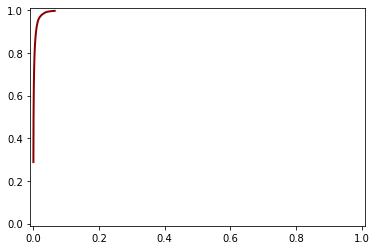

In [9]:
# Print the last ROC curve for visual verification that we catch the optimal point

n = len(roc_thresholds)

roc_x = np.zeros(n)
roc_y = np.zeros(n)

for i in range(n):
    roc_x[i] = vali_metrics_dicts[i][evaluation_metrics.FALSE_POSITIVE_RATE]
    roc_y[i] = vali_metrics_dicts[i][evaluation_metrics.SENSITIVITY]
    # print("Threshold = {0:4.2f}  False pos rate = {1:4.2f}  Sensitivity = {2:4.2f}"
    #       .format(roc_thresholds[i], roc_x[i], roc_y[i]))

    
plt.figure()
plt.ylim(-0.01, 1.01)
plt.xlim(-0.01, 1.01)
plt.plot(roc_x, roc_y, color='darkred', lw=2)

In [10]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: c:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationStudy_2020-01-07_12-33-21.csv


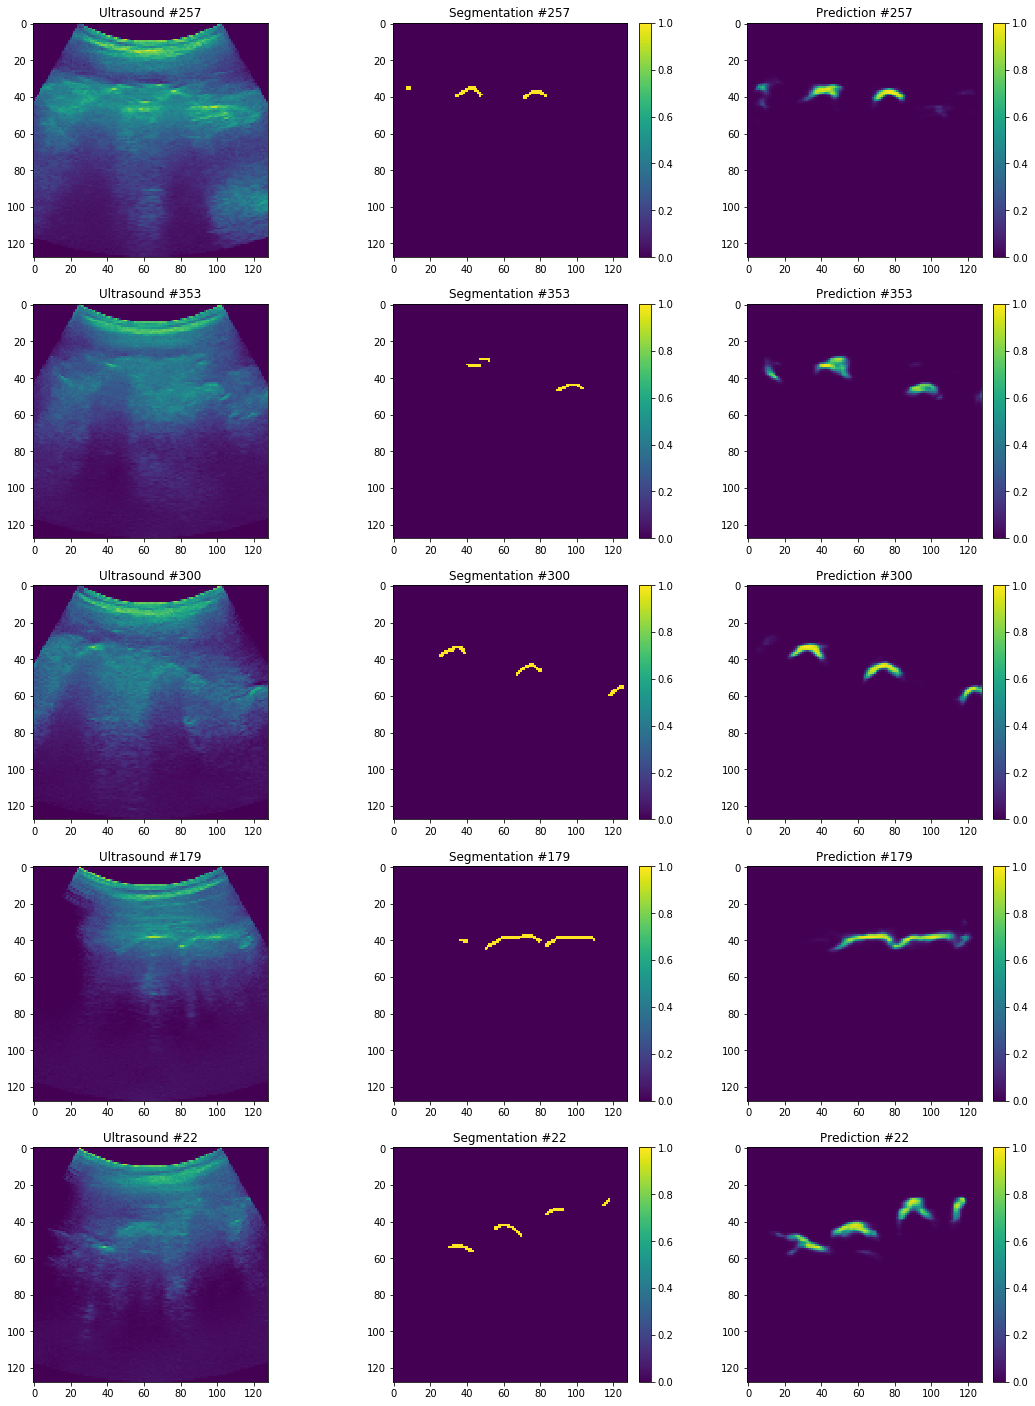

In [12]:
# Display sample results

num_vali = val_ultrasound_data.shape[0]
num_show = 5

indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)

# Uncomment for comparing the same images
# sample_indices = [105, 195, 391, 133, 142]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(np.flipud(val_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(np.flipud(val_segmentation_data_onehot[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(np.flipud(y_pred_val[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [13]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [14]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: c:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationStudy_2020-01-07_12-33-21.html
